Project File: Fake News Detector
==============

# 1. Preparation

## 1.1 Import Libraries

In [62]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import PassiveAggressiveClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import spacy



## 1.2 Import Data Sets

In [20]:
df = pd.read_csv('data/train.csv')
df

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [58]:
examples = df.sample(n=10)
examples


,id,title,author,text,label
5756,5756,Gingrich: ’Congress Should Now Intervene and S...,Trent Baker,Former House Speaker Newt Gingrich said Sunday...,0
5331,5331,Margaret Flowers’ Retrospective on Running as ...,Dr. Marsha Coleman-Adebayo,2016 elections by BAR editor and columnist Dr....,1
1737,1737,Online School Enriches Affiliated Companies if...,Motoko Rich,"COLUMBUS, Ohio — The Electronic Classroom o...",0
16066,16066,The Most Important Concepts The Manosphere Tau...,Jean-Batave Poqueliche,The Most Important Concepts The Manosphere T...,1
1105,1105,Are Native Americans Part of the Ten Lost Trib...,admin,Are Native Americans Part of the Ten Lost Trib...,1
8290,8290,"Theresa May, Donald Trump, Hillary Clinton: Yo...",Andrea Kannapell and Sandra Stevenson,(Want to get this briefing by email? Here’s th...,0
18102,18102,President-elect Trump to Become Honorary Scout...,NaN,"Monday, 14 November 2016 New addition to Boy S...",1
4484,4484,Where Burning Effigies (Not Just Guy Fawkes’s)...,Stephen Castle,"LEWES, England — Though it is never flatter...",0
18080,18080,AT&T Helping Feds Spy On Everyone,Activist Post,By Michael Maharrey Communications company AT&...,1
15170,15170,Acting FBI Director: There Has Been ’No Effort...,Kristina Wong,Acting FBI Director Andrew McCabe told senator...,0


In [59]:
examples['title'].values

array(['Gingrich: ’Congress Should Now Intervene and Should Abolish the Independent Counsel’ - Breitbart',
       'Margaret Flowers’ Retrospective on Running as a Green for the U.S. Senate',
       'Online School Enriches Affiliated Companies if Not Its Students - The New York Times',
       'The Most Important Concepts The Manosphere Taught Me',
       'Are Native Americans Part of the Ten Lost Tribes of the Jewish People?',
       'Theresa May, Donald Trump, Hillary Clinton: Your Wednesday Evening Briefing - The New York Times',
       'President-elect Trump to Become Honorary Scoutmaster',
       'Where Burning Effigies (Not Just Guy Fawkes’s) Is Part of the Fun - The New York Times',
       'AT&T Helping Feds Spy On Everyone',
       'Acting FBI Director: There Has Been ’No Effort’ to Impede Russia Investigation - Breitbart'],
      dtype=object)

In [26]:
examples['text'][18951]

"link The simple fact is that this is not a Cold War Mark II - far from it. Russia with its declining economy is nothing like the Soviet Union, which aspired to establish a different world order to that pursued by the capitalist West. Russia is in many ways a weak country. Its leadership has a strong sense of encirclement - a view that the West is only eager to do it down - and, rightly or wrongly, this is driving Mr Putin's more assertive approach. SOURCE The article linked above is the most chilling piece I've read yet concerning the current tensions with Russia. The fact it was published by the BBC doesn't help. The article should put to rest a lot of the counter-arguments in recent WW3 threads. That is not good news. The situation is clearly worse than we're being told. edit on 27-10-2016 by Profusion because: (no reason given)"

## 2.1 Data Cleaning

In [185]:
# check on the balance of the label column
df['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

Looks very good from for the further analysis! But, I hope that's not a representative sample! :(

In [6]:
# Get an overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


Seems there are some missing values especially in the author column. I'll not use that column anyway, so I will concentrate on title and text for now.

In [7]:
# reduce the dataframe to usable columns
df = df[['title','text','label']]

In [8]:
# check on missing values
df.isna().sum()

title    558
text      39
label      0
dtype: int64

In [9]:
# drop missing values
df.dropna(how='any', inplace=True)

C:\Users\flanc\.conda\envs\iron\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [10]:
df.isna().sum()

title    0
text     0
label    0
dtype: int64

In [11]:
df.shape

(20203, 3)

So, I lost in total around 600 rows which is 3% of the dataset.

In [12]:
# having a closer look into the data
df.head(50)

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1
5,Jackie Mason: Hollywood Would Love Trump if He...,"In these trying times, Jackie Mason is the Voi...",0
6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,Ever wonder how Britain’s most iconic pop pian...,1
7,Benoît Hamon Wins French Socialist Party’s Pre...,"PARIS — France chose an idealistic, traditi...",0
8,Excerpts From a Draft Script for Donald Trump’...,Donald J. Trump is scheduled to make a highly ...,0
9,"A Back-Channel Plan for Ukraine and Russia, Co...",A week before Michael T. Flynn resigned as nat...,0


In line 47 I notice an article in russian. I need to check if that is an execption or not.

### Language Detection

In [13]:
# I use Python's langdetect 
from langdetect import detect


# a function that detects the language
def language_detection(text):
    try:
        return detect(text)
    except:
        return None

In [14]:
# create a new column that contains the language identifier
df['language'] = df['text'].apply(language_detection)

C:\Users\flanc\AppData\Local\Temp/ipykernel_19944/1040549412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['language'] = df['text'].apply(language_detection)


In [15]:
df['language'].value_counts()

en       19640
ru         156
es         140
de          92
fr          37
ar          19
pt           8
tr           7
hr           5
it           5
no           4
pl           3
nl           3
af           2
el           2
zh-cn        1
tl           1
Name: language, dtype: int64

As I feared, this one article was no exception. Around 560 articles are in a foreign language. Intestingly, the majority in Russian followed by Spanish, which makes more sense!

In [16]:
# Let's see how the labels are distributed on the languages.
pd.crosstab(df['language'],df['label'])

label,0,1
language,,
af,0,2
ar,0,19
de,0,92
el,0,2
en,10384,9256
es,0,140
fr,1,36
hr,0,5
it,0,5


The vast majority of the foreign articles are considered to be unreliable. 

In [17]:
# Kick out non-english articles
df = df[df['language'] == 'en']
df.shape

(19640, 4)

In [24]:
# Export dataframe
df.to_csv('data/df.csv', index=False)

In [68]:
# read data
df = pd.read_csv('data/df.csv')

In [5]:
df['label'].value_counts()

0    10384
1     9256
Name: label, dtype: int64

### Remove all the special characters numbers and punctuations

In [69]:
# this function might become handy

def clean_article(x):
    x = str(x).lower().replace("\\"," ").replace("_"," ")
    x = re.sub(r"(W|w)on(\'|\’)t ", "will not ", x)
    x = re.sub(r"(C|c)an(\'|\’)t ", "can not ", x)
    x = re.sub(r"(Y|y)(\'|\’)all ", "you all ", x)
    x = re.sub(r"(Y|y)a(\'|\’)ll ", "you all ", x)
    x = re.sub(r"(I|i)(\'|\’)m ", "i am ", x)
    x = re.sub(r"(A|a)in(\'|\’)t ", "is not ", x)
    x = re.sub(r"n(\'|\’)t ", " not ", x)
    x = re.sub(r"(\'|\’)re ", " are ", x)
    x = re.sub(r"(\'|\’)s ", " is ", x)
    x = re.sub(r"(\'|\’)d ", " would ", x)
    x = re.sub(r"(\'|\’)ll ", " will ", x)
    x = re.sub(r"(\'|\’)t ", " not ", x)
    x = re.sub(r"(\'|\’)ve ", " have ", x)
    x = re.sub(r'\W+',' ',x) # Replace everything non-alpahnumeric by ' '
    x = re.sub(r'\s+',' ',x) # Replace one or more whitespaces by  ' '
    x = re.sub(r'\d+',' ',x) # Replace one or more digits by  ' '
    x = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'," ", x) # Replace e-mails by ''
    # Replace urls by ''
    x = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ' , x) 
    # Replace html tags by ''
    x = BeautifulSoup(x, 'html.parser').get_text().strip()
    # Remove breaks
    x = x.replace(' br ',' ')
    # Remove standalone t and s from apostrophe removal
    #x = re.sub(r"\s*'\s*\w*",'',x)
    x = re.sub(' +', ' ',x) # Replace one or more spaces by  ' '

    return x

In [70]:
df['clean'] = df['text'].apply(clean_article)

In [102]:
df

,Unnamed: 0,title,text,label,language,clean
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,en,house dem aide we did not even see comey is le...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,en,ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,en,why the truth might get you fired october the ...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,en,videos civilians killed in single us airstrike...
4,4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,en,print an iranian woman has been sentenced to s...
...,...,...,...,...,...,...
19635,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...,0,en,rapper t i unloaded on black celebrities who m...
19636,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...,0,en,when the green bay packers lost to the washing...
19637,20797,Macy’s Is Said to Receive Takeover Approach by...,The Macy’s of today grew from the union of sev...,0,en,the macy is of today grew from the union of se...
19638,20798,"NATO, Russia To Hold Parallel Exercises In Bal...","NATO, Russia To Hold Parallel Exercises In Bal...",1,en,nato russia to hold parallel exercises in balk...


## 2.2 Data processing

### Lemmanize with spaCy model

In [71]:
# load the library and the pipeline
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
#nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [72]:
# function for the stopwords
def get_stopwords():
    "Return a set of stopwords read in from nltk"
    from nltk.corpus import stopwords
    # Convert to set for performance
    stopwords_set = set(list(stopwords.words('english')))
    return stopwords_set

stop_words = get_stopwords()

In [73]:
# function that will not only lemmatize the article, but exclude the stop words and make everthing lower case
def lemmatize(text):
    """Perform lemmatization and stopword removal in the clean text
       Returns a list of lemmas
    """
    doc = nlp(text)
    lemma_list = " ".join([str(tok.lemma_).lower() for tok in doc
                  if tok.is_alpha and tok.text.lower() not in stop_words])
    return lemma_list

I'll skip explizit datacleaning for now, as I can set-up the lemmatize function to do so as well, so no need to do it beforehand. Also, the cleaning function might delete apostrophs in word's like don't or wouldn't and make it harder for spacy to find the root of the words.

In [202]:
# create a sample for testing purposes

df_sample = df.sample(n=30)
#df_sample.drop(['Unnamed: 0'],axis=1,inplace=True)
df_sample['preproc'] = df_sample['text'].apply(lemmatize)
df_sample.head(3)


C:\Users\flanc\.conda\envs\iron\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,title,text,label,language,preproc
14608,America’s Primal Scream: David Icke Explains R...,Latest Posts 21wire We are a North American an...,1,en,latest posts north american european based gra...
445,Obama: Hillary Clinton Pardon Could Heal Divid...,Note to President Obama: a Hillary Clinton par...,1,en,note president obama hillary clinton pardon co...
12729,House Majority Ldr McCarthy on Sessions-Russia...,"Thursday on MSNBC’s “Morning Joe,” House Major...",0,en,thursday msnbc morning joe house majority lead...


### Lemmatize the whole dataframe

In [74]:
df['lemma'] = df['clean'].apply(lemmatize)
df.head(10)

,Unnamed: 0,title,text,label,language,clean,lemma
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,en,house dem aide we did not even see comey is le...,house dem aide even see comey letter jason cha...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,en,ever get the feeling your life circles the rou...,ever get feeling life circle roundabout rather...
2,2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,en,why the truth might get you fired october the ...,truth might get fire october tension intellige...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,en,videos civilians killed in single us airstrike...,video civilian kill single us airstrike identi...
4,4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,en,print an iranian woman has been sentenced to s...,print iranian woman sentence six year prison i...
5,5,Jackie Mason: Hollywood Would Love Trump if He...,"In these trying times, Jackie Mason is the Voi...",0,en,in these trying times jackie mason is the voic...,try time jackie mason voice reason week exclus...
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,Ever wonder how Britain’s most iconic pop pian...,1,en,ever wonder how britain is most iconic pop pia...,ever wonder britain iconic pop pianist get lon...
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,"PARIS — France chose an idealistic, traditi...",0,en,paris france chose an idealistic traditional c...,paris france choose idealistic traditional can...
8,8,Excerpts From a Draft Script for Donald Trump’...,Donald J. Trump is scheduled to make a highly ...,0,en,donald j trump is scheduled to make a highly a...,donald j trump schedule make highly anticipate...
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",A week before Michael T. Flynn resigned as nat...,0,en,a week before michael t flynn resigned as nati...,week michael flynn resign national security ad...


In [153]:
# Export dataframe
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.to_csv('data/df_lem.csv',index=False)

In [154]:
# read in the data set again
df = pd.read_csv('data/df_lem.csv')
df

,title,text,label,language,clean,lemma
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,en,house dem aide we did not even see comey is le...,house dem aide even see comey letter jason cha...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,en,ever get the feeling your life circles the rou...,ever get feeling life circles roundabout rathe...
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,en,why the truth might get you fired october the ...,truth might get fired october tension intellig...
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,en,videos civilians killed in single us airstrike...,videos civilians killed single us airstrike id...
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,en,print an iranian woman has been sentenced to s...,print iranian woman sentenced six years prison...
...,...,...,...,...,...,...
19635,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...,0,en,rapper t i unloaded on black celebrities who m...,rapper unloaded black celebrities met donald t...
19636,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...,0,en,when the green bay packers lost to the washing...,green bay packers lost washington redskins wee...
19637,Macy’s Is Said to Receive Takeover Approach by...,The Macy’s of today grew from the union of sev...,0,en,the macy is of today grew from the union of se...,macy today grew union several great names amer...
19638,"NATO, Russia To Hold Parallel Exercises In Bal...","NATO, Russia To Hold Parallel Exercises In Bal...",1,en,nato russia to hold parallel exercises in balk...,nato russia hold parallel exercises balkans pr...


### TF-IDF: Term Frequency Inverse Document Frequency

TF-IDF is a measure of originality of a word by compraing the number of times a word apprears in a document with the number of all documents the word appears in.

In [75]:
# I use the vectorizer with 1 to 3 word combinations (n-grams) and a total of 30,000 features
tfidf = TfidfVectorizer(max_features = 30000, ngram_range = (1,3), analyzer = 'word')

In [76]:
X = tfidf.fit_transform(df['lemma'])
y = df['label']

In [8]:
X

<19640x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 5963846 stored elements in Compressed Sparse Row format>

In [77]:
tfidf.get_feature_names()

['aa',
 'aaron',
 'aaron klein',
 'aaron klein breitbart',
 'aaron klein investigative',
 'aaronkleinshow',
 'aaronkleinshow follow',
 'aaronkleinshow follow facebook',
 'abadi',
 'abandon',
 'abandonment',
 'abbas',
 'abbott',
 'abc',
 'abc news',
 'abc week',
 'abdel',
 'abdel fattah',
 'abduct',
 'abduction',
 'abdul',
 'abdullah',
 'abe',
 'abedin',
 'abedin email',
 'abet',
 'abide',
 'ability',
 'abject',
 'able',
 'able afford',
 'able find',
 'able get',
 'able keep',
 'able make',
 'able see',
 'able stream',
 'able stream episode',
 'able take',
 'able use',
 'abnormal',
 'aboard',
 'abolish',
 'aboriginal',
 'aborigine',
 'abort',
 'abortion',
 'abortion clinic',
 'abortion right',
 'abound',
 'abraham',
 'abraham lincoln',
 'abramovic',
 'abrams',
 'abroad',
 'abrupt',
 'abruptly',
 'absence',
 'absent',
 'absentee',
 'absentee ballot',
 'absolute',
 'absolute good',
 'absolute good food',
 'absolutely',
 'absolutely nothing',
 'absorb',
 'absorption',
 'abstain',
 'abstent

## 2.4 EDA

In [78]:
# create column with total words per article
df['totalwords'] = [len(x.split()) for x in df['clean'].tolist()]
# create column with average word length
df['avgwordlength'] = [len(x)/len(x.split()) for x in df['clean'].tolist()]

#### Plot histogramms on the article and word lengths

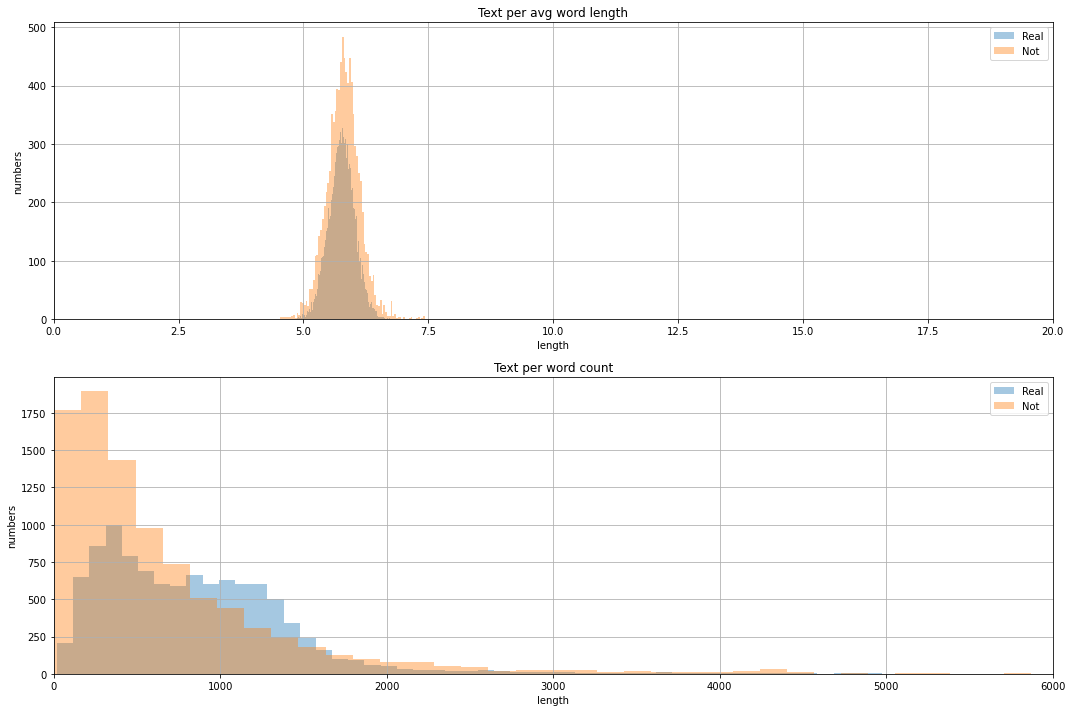

In [79]:
f, ax = plt.subplots(2,1,figsize=(15,10))

ax[0].set_title('Text per avg word length')
ax[0].hist(df[df['label'] == 0]['avgwordlength'], alpha = 0.4, bins=150, label = 'Real')
ax[0].hist(df[df['label'] == 1]['avgwordlength'], alpha = 0.4, bins=150, label = 'Not')
ax[0].set_xlabel('length')
ax[0].set_ylabel('numbers')
ax[0].legend(loc='upper right')
ax[0].set_xlim(0,20)
ax[0].grid()

ax[1].set_title('Text per word count')
ax[1].hist(df[df['label'] == 0]['totalwords'], alpha = 0.4, bins=150, label = 'Real')
ax[1].hist(df[df['label'] == 1]['totalwords'], alpha = 0.4, bins=150, label = 'Not')
ax[1].set_xlabel('length')
ax[1].set_ylabel('numbers')
ax[1].legend(loc='upper right')
ax[1].set_xlim(0,6000)
ax[1].grid()

f.tight_layout()
plt.show()

#### Word Clouds

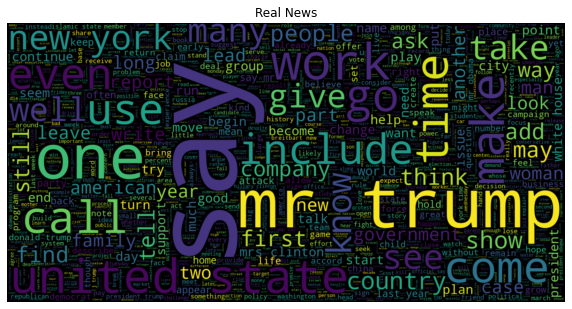

In [80]:
# create a word cloud for the reliable news articles only 
from wordcloud import WordCloud
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(df[df.label == 0].lemma))
plt.axis('off')
plt.title('Real News')
plt.imshow(wc,interpolation = 'bilinear')

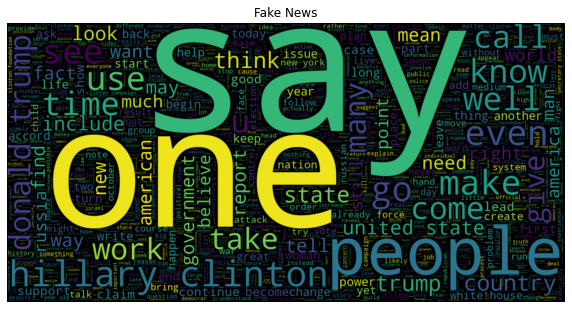

In [81]:
# now let's create a word cloud for the unreliable news articles only 
from wordcloud import WordCloud
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(df[df.label == 1].lemma))
plt.axis('off')
plt.title('Fake News')
plt.imshow(wc,interpolation = 'bilinear')

#### Explore TF-IDF vocabulary and scores 

### Train-Test-Split

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=666)

In [83]:
# X: data points
# y: targets (data points` label)
# vectorizer: TFIDF vectorizer created by sklearn
# n: number of features that we want to list for each class
# target_list: the list of all unique labels (for example, in my case I have two labels: 1 and -1 and target_list = [1, -1])
# --------------------------------------------
# splitting X vectors based on target classes
import operator
from prettytable import PrettyTable
target_list = [0,1]
for label in target_list:
    # listing the most important words in each class
    indices = []
    current_dict = {}
    #title
    if label == 0:
        print ('Real News')
    else:
        print ('Fake News')
    # finding indices the of rows (data points) for the current class
    for i in range(0, len(X.toarray())):
        if y[i] == label:
            indices.append(i)

    # get rows of the current class from tf-idf vectors matrix and calculating the mean of features values
    vectors = np.mean(X[indices, :], axis=0)

    # creating a dictionary of features with their corresponding values
    for i in range(0, X.shape[1]):
        current_dict[X.indices[i]] = vectors.item((0, i))

    # sorting the dictionary based on values
    sorted_dict = sorted(current_dict.items(), key=operator.itemgetter(1), reverse=True)

    # printing the features textual and numeric values
    index = 1
    t=PrettyTable(['#','n-gram','score'])
    for element in sorted_dict:
        for key_, value_ in tfidf.vocabulary_.items():
            if element[0] == value_:
                #print(str(index) + "\t" + str(key_) + "\t" + str(element[1]))
                t.add_row([index,key_,round(element[1],3)])
                index += 1
                if index == 11:
                    break
        else:
            continue
        break
    print(t)

Real News
+----+-----------------+-------+
| #  |      n-gram     | score |
+----+-----------------+-------+
| 1  |     neither     | 0.065 |
| 2  |    could make   |  0.04 |
| 3  |       rent      |  0.02 |
| 4  |       turn      |  0.02 |
| 5  |      nobody     | 0.018 |
| 6  |    woman know   | 0.018 |
| 7  |   gang member   | 0.018 |
| 8  |   could reach   | 0.015 |
| 9  |       aka       | 0.014 |
| 10 | social security | 0.013 |
+----+-----------------+-------+
Fake News
+----+-------------+-------+
| #  |    n-gram   | score |
+----+-------------+-------+
| 1  |  could make | 0.033 |
| 2  |     turn    | 0.016 |
| 3  |    nobody   | 0.016 |
| 4  | could reach | 0.015 |
| 5  |    cause    | 0.014 |
| 6  |   sciences  | 0.014 |
| 7  |    choice   | 0.014 |
| 8  |    sunni    | 0.013 |
| 9  | gang member | 0.013 |
| 10 |   congress  | 0.013 |
+----+-------------+-------+


In [95]:
target_list = [0,1]
for label in target_list:
    # listing the most important words in each class
    indices = []
    current_dict = {}
    #title
    if label == 0:
        print ('Real News')
    else:
        print ('Fake News')
    # finding indices the of rows (data points) for the current class
    for i in range(0, len(X.toarray())):
        if y[i] == label:
            indices.append(i)

    # get rows of the current class from tf-idf vectors matrix and calculating the mean of features values
    vectors = np.mean(X[indices, :], axis=0)
    print(np.mean(vectors[0]))

Real News
0.0004201878645848483
Fake News
0.00037403763847577065


## 3.1 Modeling

In [84]:
# function to evaluate the model performance

def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import cohen_kappa_score, classification_report 


    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

### Random Forests

#### Grid Search Random Forest

In [8]:
# set up parameters for grid search in random forests
parameters = {
    'n_estimators': [20,50,100],
    'max_depth': [50,100, 200]    
} 
regressor = GridSearchCV(RandomForestClassifier(), parameters, verbose=1,cv=5,n_jobs=-1) 
regressor.fit(X_train,y_train) 
print(regressor.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'max_depth': 200, 'n_estimators': 100}


#### Fit Random Forests with best parameters

In [87]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=200, n_estimators=100)

y_train = y_train.astype('int')
y_test  = y_test.astype('int')

rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf  = rf.predict(X_test)

#### Model Performance

In [88]:
model_performance_class(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7285
           1       1.00      1.00      1.00      6463

    accuracy                           1.00     13748
   macro avg       1.00      1.00      1.00     13748
weighted avg       1.00      1.00      1.00     13748

Results obtained for the TEST SET
The Cohen's Kappa is: 0.90
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3099
           1       0.96      0.94      0.95      2793

    accuracy                           0.95      5892
   macro avg       0.95      0.95      0.95      5892
weighted avg       0.95      0.95      0.95      5892



#### K-Fold Cross Validation

In [89]:
# evaluate model
scores = cross_val_score(rf, X, y, scoring='accuracy', cv=5, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.947 (0.003)


### XGBOOST


#### Grid Search XGBOOST

In [10]:
# set up parameters for grid search in xgboost
parameters = {
    'learning_rate': [0.1, 0.01, 0.05]
}
regressor = GridSearchCV(XGBClassifier(), parameters, verbose=1,cv=5,n_jobs=-1) 
regressor.fit(X_train,y_train) 
print(regressor.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\flanc\.conda\envs\iron\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:51:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'learning_rate': 0.1}


#### Model performance

In [90]:
xgb = XGBClassifier(max_depth=200, n_estimators=100, learning_rate=0.1)
xgb.fit(X_train, y_train)

y_train_pred_xgb = xgb.predict(X_train)
y_test_pred_xgb  = xgb.predict(X_test)

print(model_performance_class(y_train, y_train_pred_xgb, y_test, y_test_pred_xgb))

C:\Users\flanc\.conda\envs\iron\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:10:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Results obtained for the TRAIN SET
The Cohen's Kappa is: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7285
           1       1.00      1.00      1.00      6463

    accuracy                           1.00     13748
   macro avg       1.00      1.00      1.00     13748
weighted avg       1.00      1.00      1.00     13748

Results obtained for the TEST SET
The Cohen's Kappa is: 0.91
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3099
           1       0.95      0.96      0.95      2793

    accuracy                           0.96      5892
   macro avg       0.96      0.96      0.96      5892
weighted avg       0.96   

#### K-Fold Cross Validation

In [91]:
# evaluate model
scores = cross_val_score(xgb, X, y, scoring='accuracy', cv=5, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.951 (0.004)


### Passive Aggressive

#### Grid Search Passive Agrressive

In [ ]:
parameters = {
    'C': [0.5,1.0,1.5],
    'max_iter': [50,100,200,500, 1000, 1500]    
} 
regressor = GridSearchCV(PassiveAggressiveClassifier(), parameters, verbose=1,cv=5,n_jobs=-1) 
regressor.fit(X_train,y_train) 
print(regressor.best_params_)

#### Model performance

In [85]:
pac = PassiveAggressiveClassifier(C = 1, max_iter=200)

pac.fit(X_train, y_train)

y_train_pred_pac = pac.predict(X_train)
y_test_pred_pac  = pac.predict(X_test)

print(model_performance_class(y_train, y_train_pred_pac, y_test, y_test_pred_pac))

Results obtained for the TRAIN SET
The Cohen's Kappa is: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7285
           1       1.00      1.00      1.00      6463

    accuracy                           1.00     13748
   macro avg       1.00      1.00      1.00     13748
weighted avg       1.00      1.00      1.00     13748

Results obtained for the TEST SET
The Cohen's Kappa is: 0.93
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3099
           1       0.96      0.96      0.96      2793

    accuracy                           0.96      5892
   macro avg       0.96      0.96      0.96      5892
weighted avg       0.96      0.96      0.96      5892

None


#### K-Fold Cross Validation

In [92]:
# evaluate model
scores = cross_val_score(pac, X, y, scoring='accuracy', cv=5, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.966 (0.003)


## Test the code

In [93]:
# save variables
import pickle
# Open a file and use dump()
with open('variables.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump([nlp,stop_words,tfidf,pac], file)

In [ ]:
# load variables
with open('variables.pkl', 'rb') as file:
      
    # create new variables from the pickle file
    nlp,stop_words,tfidf,pac = pickle.load(file)

In [63]:
# load the library and the pipeline

nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'ner'])
#nlp.add_pipe(nlp.create_pipe('sentencizer'))

# function for the stopwords
def get_stopwords():
    "Return a set of stopwords read in from nltk"
    from nltk.corpus import stopwords
    # Convert to set for performance
    stopwords_set = set(list(stopwords.words('english')))
    return stopwords_set

stop_words = get_stopwords()

def lemmatize(text):
    """Perform lemmatization and stopword removal in the clean text
       Returns a list of lemmas
    """
    doc = nlp(text)
    lemma_list = " ".join([str(tok.lemma_).lower() for tok in doc
                  if tok.is_alpha and tok.text.lower() not in stop_words])
    return lemma_list



def demo():
    user_input = input("Give me the article you want to test:")
    lemma = lemmatize(user_input)
    x_user = tfidf.transform([lemma])
    y = pac.predict(x_user)
    y_prop = pac._predict_proba_lr(x_user)
    if y[0] == 1:
        return "I'm {:.0%} sure, that's FAKE!".format(y_prop[0][1])
    else: 
        return "That sounds real! Like {:.0%} plausible!".format(y_prop[0][0])   

In [89]:
demo()

'That sounds real! Like 61% plausible!'

# Appendix

In [64]:
user_input = input("Give me the article you want to test:")
lemma = lemmatize(user_input)
x_user = tfidf.transform([lemma])
y = pac.predict(x_user)

C:\Users\flanc\.conda\envs\iron\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


NameError: name 'tfidf' is not defined

1

In [23]:
sorted_dict

[(15218, 0.033013075204171044),
 (16134, 0.02140585457536266),
 (4943, 0.017537809819069636),
 (26499, 0.015345451886161618),
 (25419, 0.014721145409092768),
 (26861, 0.013587171156668857),
 (8986, 0.013004805515722391),
 (230, 0.012674632396246686),
 (20583, 0.012144712071549393),
 (23905, 0.011819563767470648),
 (11827, 0.011572997590387497),
 (20212, 0.01103473118607946),
 (1979, 0.009665234342304391),
 (6539, 0.009105466928904547),
 (13548, 0.008917207876721615),
 (9837, 0.008426054973384733),
 (9042, 0.008346362938540578),
 (18632, 0.008342798026037124),
 (8151, 0.008185872469146198),
 (23185, 0.008052297281028332),
 (3175, 0.007959676718349289),
 (18095, 0.00793537571799572),
 (17976, 0.007916305571485661),
 (24431, 0.0076828381297743735),
 (17659, 0.007478983774643574),
 (6968, 0.00740462722718713),
 (13460, 0.007287727285333901),
 (10436, 0.0071853482756703115),
 (28360, 0.007067822001257403),
 (13576, 0.007048584327928469),
 (3833, 0.007042828900745178),
 (18677, 0.00687659178

In [11]:
from joblib import Parallel, delayed

def lemmatize_pipe(doc):
    lemma_list = [str(tok.lemma_).lower() for tok in doc
                  if tok.is_alpha and tok.text.lower() not in stop_words] 
    return lemma_list

def preprocess_pipe(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe

def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]

def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe

def preprocess_parallel(texts, chunksize=100):
    executor = Parallel(n_jobs=7, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(df_sample), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

### Bag of Words

I'll create a corpus with all possible words from each and every article in the database.

In [16]:
articles = ['']
corpus=[]
for article in df['lemma']:
    articles.append(article)
    corpus.append(nltk.sent_tokenize(article))  

In [17]:
## flatten the list
corpus=[sent for sublist in corpus for sent in sublist]
len(corpus)

19640

### Stemming

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")
corpus_lem = []

for text in corpus:
   doc = nlp(text)
   corpus_lem.append(' '.join([token.lemma_ for token in doc]))

In [47]:
corpus_lem

['House dem aide : we do not even see Comey ’s Letter until Jason Chaffetz tweet it by Darrell Lucus on October 30 , 2016 Subscribe Jason Chaffetz on the stump in American Fork , Utah ( image courtesy Michael Jolley , available under a Creative Commons - by license ) \n with apology to Keith Olbermann , there be no doubt who the Worst Person in the World be this week – FBI Director James Comey .',
 'but accord to a House democratic aide , it look like we also know who the second - bad person be as well .',
 'it turn out that when Comey send his now - infamous letter announce that the FBI be look into email that may be relate to Hillary Clinton ’s email server , the rank Democrats on the relevant committee do not hear about it from Comey .',
 'they find out via a tweet from one of the Republican committee chairman .',
 'as we now know , Comey notify the republican chairman and democratic rank member of the House Intelligence , Judiciary , and Oversight committee that his agency be revie

In [128]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
porter = PorterStemmer()
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [134]:
test = list(map(lambda x: stemSentence(x),test_corpus))

In [135]:
test

['hous dem aid : We didn ’ t even see comey ’ s letter until jason chaffetz tweet It By darrel lucu on octob 30 , 2016 subscrib jason chaffetz on the stump in american fork , utah ( imag courtesi michael jolley , avail under a creativ commons-bi licens ) with apolog to keith olbermann , there is no doubt who the worst person in the world is thi week–fbi director jame comey . ',
 'but accord to a hous democrat aid , it look like we also know who the second-worst person is as well . ',
 'It turn out that when comey sent hi now-infam letter announc that the fbi wa look into email that may be relat to hillari clinton ’ s email server , the rank democrat on the relev committe didn ’ t hear about it from comey . ',
 'they found out via a tweet from one of the republican committe chairmen . ',
 'As we now know , comey notifi the republican chairmen and democrat rank member of the hous intellig , judiciari , and oversight committe that hi agenc wa review email it had recent discov in order to 

### Remove all the special characters numbers and punctuations

In [109]:
# this function might become handy

def clean_article(x):
    x = str(x).lower().replace("\\"," ").replace("_"," ")
    x = re.sub(r"(W|w)on(\'|\’)t ", "will not ", x)
    x = re.sub(r"(C|c)an(\'|\’)t ", "can not ", x)
    x = re.sub(r"(Y|y)(\'|\’)all ", "you all ", x)
    x = re.sub(r"(Y|y)a(\'|\’)ll ", "you all ", x)
    x = re.sub(r"(I|i)(\'|\’)m ", "i am ", x)
    x = re.sub(r"(A|a)in(\'|\’)t ", "is not ", x)
    x = re.sub(r"n(\'|\’)t ", " not ", x)
    x = re.sub(r"(\'|\’)re ", " are ", x)
    x = re.sub(r"(\'|\’)s ", " is ", x)
    x = re.sub(r"(\'|\’)d ", " would ", x)
    x = re.sub(r"(\'|\’)ll ", " will ", x)
    x = re.sub(r"(\'|\’)t ", " not ", x)
    x = re.sub(r"(\'|\’)ve ", " have ", x)
    x = re.sub(r'\W+',' ',x) # Replace everything non-alpahnumeric by ' '
    x = re.sub(r'\s+',' ',x) # Replace one or more whitespaces by  ' '
    x = re.sub(r'\d+',' ',x) # Replace one or more digits by  ' '
    x = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'," ", x) # Replace e-mails by ''
    # Replace urls by ''
    x = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ' , x) 
    # Replace html tags by ''
    x = BeautifulSoup(x, 'html.parser').get_text().strip()
    # Remove breaks
    x = x.replace(' br ',' ')
    # Remove standalone t and s from apostrophe removal
    #x = re.sub(r"\s*'\s*\w*",'',x)
    x = re.sub(' +', ' ',x) # Replace one or more spaces by  ' '

    return x

In [110]:
clean_article('In fact, the Democratic Ranking Members 555462 didn’t receive it they’re until after the Chairman of the Oversight and Government Reform Committee, Jason Chaffetz, tweeted it out and made it public.” \nSo let’s see if we’ve got this right.')


'in fact the democratic ranking members didn t receive it they re until after the chairman of the oversight and government reform committee jason chaffetz tweeted it out and made it public so let s see if we ve got this right'

In [108]:
#corpus_clean = []
corpus_clean = list(map(lambda x: clean_article(x),corpus))

In [103]:
corpus_clean

['house dem aide we didn even see comey letter until jason chaffetz tweeted it by darrell lucus on october subscribe jason chaffetz on the stump in american fork utah image courtesy michael jolley available under a creative commons by license with apologies to keith olbermann there is no doubt who the worst person in the world is this week fbi director james comey',
 'but according to a house democratic aide it looks like we also know who the second worst person is as well',
 'it turns out that when comey sent his now infamous letter announcing that the fbi was looking into emails that may be related to hillary clinton email server the ranking democrats on the relevant committees didn hear about it from comey',
 'they found out via a tweet from one of the republican committee chairmen',
 'as we now know comey notified the republican chairmen and democratic ranking members of the house intelligence judiciary and oversight committees that his agency was reviewing emails it had recently d

In [104]:
# exclude stop_words from the corpus
from nltk.corpus import stopwords # import stopwords from nltk

stop_words = list(stopwords.words('english')) 

# Clean stop_words in the same manner as I did for the text corpus

stop_words = list(map(lambda x: clean_article(x),stop_words))

In [105]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'you re',
 'you ve',
 'you ll',
 'you d',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'she s',
 'her',
 'hers',
 'herself',
 'it',
 'it s',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'that ll',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [112]:
# remove stop_words
corpus_new = [x for x in corpus_clean if x not in stop_words]
corpus_new

['house dem aide we didn t even see comey s letter until jason chaffetz tweeted it by darrell lucus on october subscribe jason chaffetz on the stump in american fork utah image courtesy michael jolley available under a creative commons by license with apologies to keith olbermann there is no doubt who the worst person in the world is this week fbi director james comey',
 'but according to a house democratic aide it looks like we also know who the second worst person is as well',
 'it turns out that when comey sent his now infamous letter announcing that the fbi was looking into emails that may be related to hillary clinton s email server the ranking democrats on the relevant committees didn t hear about it from comey',
 'they found out via a tweet from one of the republican committee chairmen',
 'as we now know comey notified the republican chairmen and democratic ranking members of the house intelligence judiciary and oversight committees that his agency was reviewing emails it had re

In [20]:
# create a dictionary to display the word frequencies

wordfreq = {}
for sentence in corpus:
    words = sentence.split()
    #tokens = nltk.word_tokenize(sentence) # To get the words, it can be also done with sentence.split()
    for word in words:
        if ( word not in wordfreq.keys() ): ## first time appearnce in the sentence
            wordfreq[word] = 1 # We initialize the corresponding counter
        else: ## if the world is already existed in the dictionalry 
            wordfreq[word] += 1 # We increase the corresponding counter

In [21]:
wordfreq

{'house': 12065,
 'dem': 67,
 'aide': 792,
 'even': 18867,
 'see': 10799,
 'comey': 3624,
 'letter': 2336,
 'jason': 566,
 'chaffetz': 174,
 'tweeted': 584,
 'darrell': 73,
 'lucus': 21,
 'october': 4536,
 'subscribe': 520,
 'stump': 83,
 'american': 16020,
 'fork': 54,
 'utah': 390,
 'image': 1727,
 'courtesy': 321,
 'michael': 2511,
 'jolley': 1,
 'available': 1929,
 'creative': 652,
 'commons': 217,
 'license': 636,
 'apologies': 84,
 'keith': 227,
 'olbermann': 9,
 'doubt': 1272,
 'worst': 1229,
 'person': 4196,
 'world': 15845,
 'week': 7519,
 'fbi': 5469,
 'director': 5183,
 'james': 2475,
 'according': 9997,
 'democratic': 5737,
 'looks': 1401,
 'like': 26250,
 'also': 25359,
 'know': 11718,
 'second': 4328,
 'well': 10725,
 'turns': 855,
 'sent': 2907,
 'infamous': 245,
 'announcing': 376,
 'looking': 2920,
 'emails': 4319,
 'may': 13119,
 'related': 1974,
 'hillary': 14629,
 'clinton': 27055,
 'email': 5733,
 'server': 1316,
 'ranking': 289,
 'democrats': 5018,
 'relevant': 52